# Download data

http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

https://rslab.ut.ac.ir/data

In [ ]:
# Salinas
!wget -q http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
!wget -q http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat

In [ ]:
!pip install earthpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import earthpy.plot as ep
import cv2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
import pickle
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'

# Data Format

In [3]:
def get_salinas_data():
  # remove -ve values from the sensor data
  x = loadmat('Salinas_corrected.mat')['salinas_corrected']
  x = x.clip(0, 2**16).astype('uint16')
  y = loadmat('Salinas_gt.mat')['salinas_gt']
  return x, y

salinas_classes = ['Unknown', 
                   'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 
                   'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 
                   'Stubble', 'Celery', 'Grapes_untrained', 
                   'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 
                   'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 
                   'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']

In [4]:
# aviris has 224 continous bands from 400nm to 2500nm
rgb_bands = (26, 16, 6) # aviris sensor

In [5]:
x, y = get_salinas_data()

In [6]:
print("x shape", x.shape) # last dim is bands
print("x dtype", x.dtype)
print("y shape", y.shape)
print("y dtype", y.dtype)

x shape (512, 217, 204)
x dtype uint16
y shape (512, 217)
y dtype uint8


# Visualize data

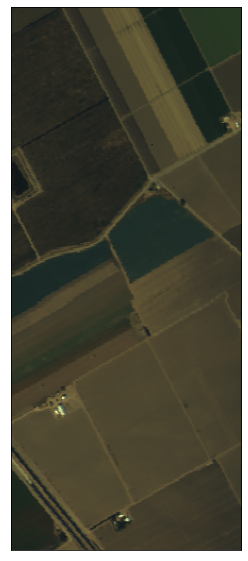

In [7]:
# rgb composite image
ep.plot_rgb(x.transpose(2, 0, 1), # bands first
            rgb=rgb_bands);

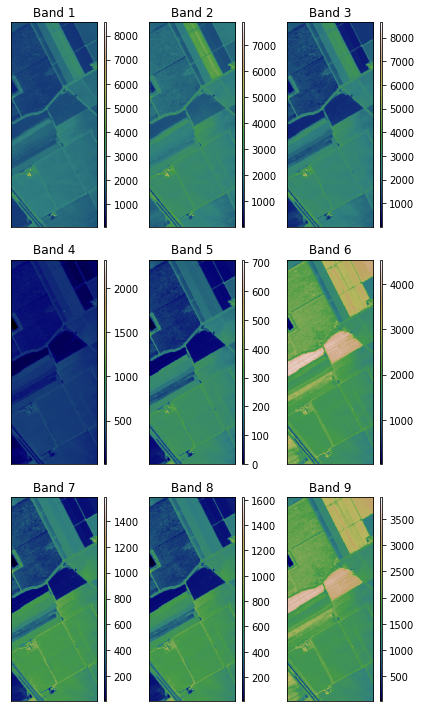

In [8]:
# plot random bands
random_bands = np.random.randint(0, x.shape[-1], 9)
ep.plot_bands(x.transpose(2, 0, 1)[random_bands], 
              cmap='gist_earth',
              figsize=(6, 10));

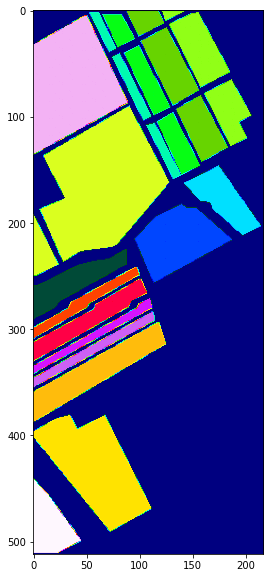

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(y, cmap='gist_ncar');

In [10]:
def visualize_class_distribtion(y, classes):
  fig, ax = plt.subplots(figsize=(8, 8))

  series = pd.Series(y.reshape(-1)).value_counts(normalize=True) * 100

  pct = series.to_numpy() # percentages

  labels = series.index.tolist() # int labels
  labels = np.array(classes)[labels] # string labels

  ax.pie(pct,
          labels=labels,
          labeldistance=1.15,
          startangle=90,
          rotatelabels=True)

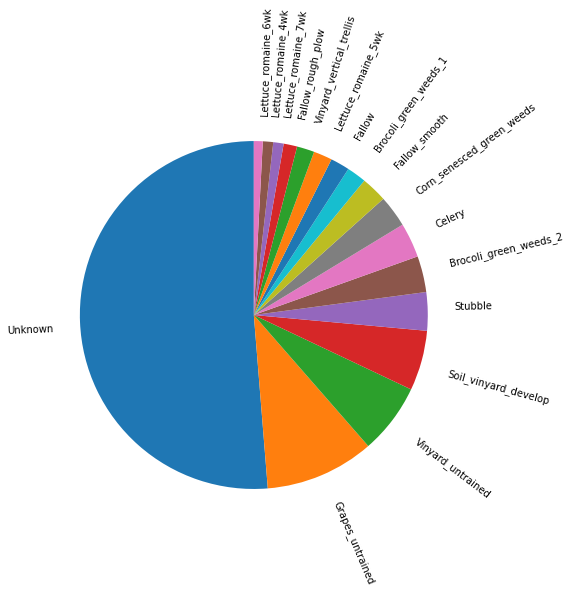

In [11]:
visualize_class_distribtion(y, salinas_classes);

# Hyperspectral Image Classification

Image Classification assigns label to image.
Hyperspectral image classification assigns label to each pixel of image. Each pixel is composed of many hyperspectral bands.

# Train test split

In [12]:
x_train, y_train = x.reshape(-1, x.shape[-1]), y.reshape(-1)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=y_train)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88883, 204)
(88883,)
(22221, 204)
(22221,)


# Scaling

Perform Feature Scaling

In [14]:
scaler = StandardScaler()
scaler.fit(x_train);

# Find PCA N Components

Starting point for n_components used in random search

In [15]:
x_train_scaled = scaler.transform(x_train);

In [16]:
pca = PCA()
pca.fit(x_train_scaled);

In [17]:
desired_variance = 99.95

# Find minimum number of components required
# to explain desired_variance
variance = np.cumsum(pca.explained_variance_ratio_) * 100
components = (variance >= desired_variance).argmax() + 1

# print
print(f"{desired_variance}% variance can be explained by {components} components")

99.95% variance can be explained by 27 components


# Create Sklearn pipeline

In [18]:
pipeline = Pipeline([
  ('preprocessing', scaler),
  ('pca', PCA()),
  ('clf', RandomForestClassifier()),
])

# Hyperparams Search

Perform Random Search for best hyperparams

In [19]:
params = {
    'pca__n_components': [25, 26, 27, 28],
    'clf': [RandomForestClassifier()],
    "clf__n_estimators": [90, 100, 110],
    'clf__class_weight': ['balanced'],
    'clf__max_features': ["sqrt"],
}

In [20]:
np.random.seed(42)
search = RandomizedSearchCV(pipeline,
                      params,
                      cv=5,
                      verbose=1,
                      n_iter=10,
                      random_state=42)

In [21]:
start_time = time.time()
results = search.fit(x_train, y_train)
print(f"Params Search Completed In {time.time()-start_time:.2f} Seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 63.1min finished


Params Search Completed In 3892.32 Seconds


In [22]:
best_accuracy = results.best_score_
print(f"Best Accuracy On Cross Validation Set {best_accuracy}")

Best Accuracy On Cross Validation Set 0.9113103756373274


In [23]:
print("Best Params")
results.best_params_

Best Params


{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=110,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'clf__class_weight': 'balanced',
 'clf__max_features': 'sqrt',
 'clf__n_estimators': 110,
 'pca__n_components': 25}

In [24]:
model = results.best_estimator_

In [25]:
y_pred = model.predict(x_train)

In [26]:
report = classification_report(y_train, y_pred, 
                               target_names=salinas_classes)
print(report)

                           precision    recall  f1-score   support

                  Unknown       1.00      0.99      0.99     45580
    Brocoli_green_weeds_1       0.98      1.00      0.99      1607
    Brocoli_green_weeds_2       0.99      1.00      1.00      2981
                   Fallow       0.99      1.00      1.00      1581
        Fallow_rough_plow       0.98      1.00      0.99      1115
            Fallow_smooth       0.99      1.00      1.00      2142
                  Stubble       0.99      1.00      0.99      3167
                   Celery       0.99      1.00      0.99      2863
         Grapes_untrained       1.00      1.00      1.00      9017
     Soil_vinyard_develop       0.99      1.00      1.00      4962
Corn_senesced_green_weeds       0.98      1.00      0.99      2622
      Lettuce_romaine_4wk       0.96      1.00      0.98       855
      Lettuce_romaine_5wk       0.97      1.00      0.99      1542
      Lettuce_romaine_6wk       0.94      1.00      0.97     

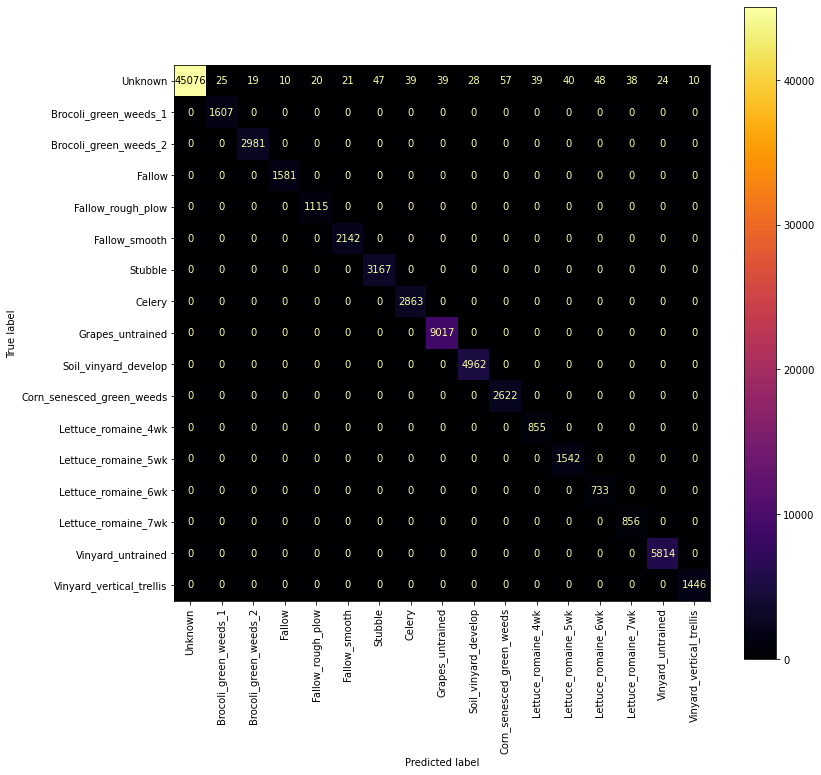

In [27]:
_, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(model, x_train, y_train, 
                      display_labels=salinas_classes,
                      xticks_rotation='vertical',
                      cmap='inferno',
                      values_format='d',
                      ax=ax);

# Save Pipeline

In [28]:
def save_model(model):
  with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
    
def load_model():
  with open("model.pkl", "rb") as f:
    return pickle.load(f)

In [29]:
model = results.best_estimator_

In [30]:
save_model(model)

# Evaluate model

In [31]:
model = load_model()

In [32]:
y_pred = model.predict(x_test)

In [33]:
report = classification_report(y_test, y_pred, 
                               target_names=salinas_classes)
print(report)

                           precision    recall  f1-score   support

                  Unknown       0.94      0.95      0.94     11395
    Brocoli_green_weeds_1       0.88      0.96      0.92       402
    Brocoli_green_weeds_2       0.94      0.97      0.96       745
                   Fallow       0.88      0.68      0.77       395
        Fallow_rough_plow       0.92      0.81      0.86       279
            Fallow_smooth       0.88      0.91      0.89       536
                  Stubble       0.95      0.97      0.96       792
                   Celery       0.94      0.97      0.95       716
         Grapes_untrained       0.83      0.92      0.87      2254
     Soil_vinyard_develop       0.95      0.91      0.93      1241
Corn_senesced_green_weeds       0.96      0.91      0.93       656
      Lettuce_romaine_4wk       0.92      0.91      0.91       213
      Lettuce_romaine_5wk       0.91      0.89      0.90       385
      Lettuce_romaine_6wk       0.85      0.83      0.84     

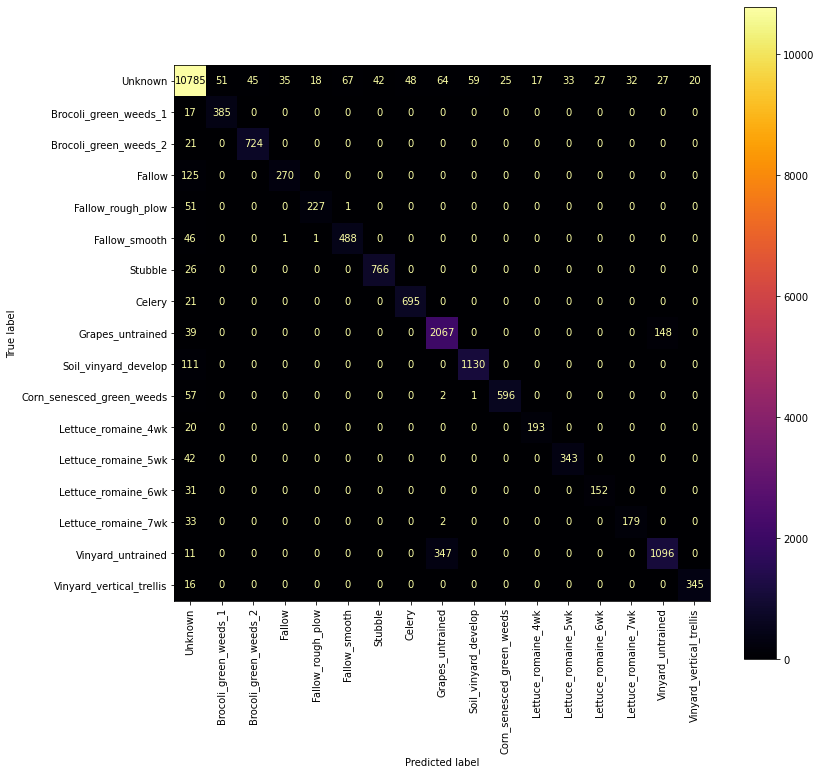

In [34]:
_, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(model, x_test, y_test, 
                      display_labels=salinas_classes,
                      xticks_rotation='vertical',
                      cmap='inferno',
                      values_format='d',
                      ax=ax);

In [35]:
pred = model.predict(x.reshape(-1, x.shape[-1]))
pred_image = pred.reshape(y.shape[0], y.shape[1])

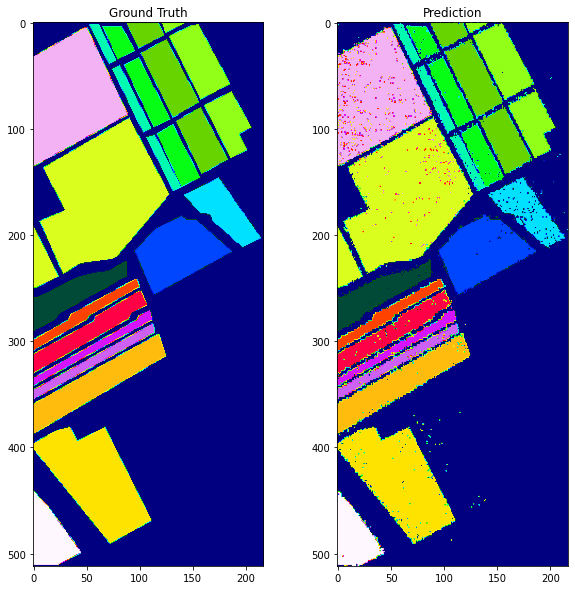

In [36]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(y, cmap='gist_ncar')
ax1.set_title("Ground Truth")
ax2.imshow(pred_image, cmap='gist_ncar')
ax2.set_title("Prediction");